# Construct school interaction networks from basic school statistics

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import construct_school_network as csn

from importlib import reload

# for progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time

## Descriptive school constants

Descriptive school statistics are inspired by [data](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) about Austrian schools from 2018.

In [11]:
# different age structures in Austrian school types
age_brackets = {'primary':[6, 7, 8, 9],
                'primary_dc':[6, 7, 8, 9],
                'unterstufe':[10, 11, 12, 13],
                'oberstufe':[14, 15, 16, 17],
                'gymnasium':[10, 11, 12, 13, 14, 15, 16, 17],
                'waldorfschule':[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
               }

In [3]:
school_characteristics = {
    # Volksschule: Schulen: 3033, Klassen: 18245, Schüler*innen: 339382
    'primary':  {'classes':8, 'students':19, 'floors':1},
    'primary_dc':  {'classes':8, 'students':19, 'floors':1},
    # Hauptschulen: 47, Klassen 104, Schüler*innen: 1993
    # Neue Mittelschule: Schulen 1131, Klassen: 10354, Schüler*innen: 205905
    # Sonderschulen: 292, Klassen: 1626, Schüler*innen: 14815
    # Polytechnische Schulen: nur Schulstufe 9, ignorieren
    # AHS Unterstufe: Schulen: 281, Klassen: 4901, Schüler*innen: 119591
    # Berufsbildende mittlere Schulen: 381, Klassen: 1981, Schüler*innen: 44048
    # Gesamt: Schulen: 2132, Klassen: 18966, Schüler*innen: 386352
    'lower_secondary':   {'classes':9, 'students':20, 'floors':1},
    'lower_secondary_dc':   {'classes':9, 'students':20, 'floors':1},
    # AHS Obserstufe: Schulen: 348, Klassen: 4119, Schüler*innen: 92193
    # Berufsbildende höhere Schulen: 353, Klassen: 6061, Schüler*innen: 143544
    # Berufsschulen: Schulen: 154, Klassen 6187, Schüler*innen: 114493
    # Gesamt: Schulen: 855, Klassen 16367, Schüler*innen: 350230
    'upper_secondary':    {'classes':19, 'students':21, 'floors':1},
    # Oberstufenrealgymnasien: Schulen: 114, Klassen: 1183, Schüler*innen 26211
    # Aufbaugymnasiuen: Schulen: 4, Klassen: 27, Schüler*innen: 601
    # Gesamt: 118, Klassen: 1210, Schüler*innen: 26812 
    'secondary':    {'classes':10, 'students':22, 'floors':1}
}

## Characteristics of Austrian families

Family sizes with children < 18 years old from the [Austrian microcensus 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/familien/index.html) (Note: 63.45 % of all households have no children), file ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_```:

* 1 child: 48.15 % (81.95 % two parents, 18.05 % single parents)
* 2 children: 38.12 % (89.70 % two parents, 10.30% single parents)
* 3 children: 10.69 % (88.26 % two parents, 11.74 % single parents)
* 4 or more children: 3.04 % (87.44 % two parents, 12.56 % single parents)

In [262]:
# given the precondition that the family has at least one child, how many
# children does the family have?
p_children = {1:0.4815, 2:0.3812, 3:0.1069, 4:0.0304}

# probability of being a single parent, depending on the number of children
p_parents = {1:{1:0.1805, 2:0.8195},
             2:{1:0.1030, 2:0.8970},
             3:{1:0.1174, 2:0.8826},
             4:{1:0.1256, 2:0.8744}
            }

General household sizes of households with one family (2.51% of households have more than one family) [Austrain household statistics 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/haushalte/index.html), files 
* ```ergebnisse_im_ueberblick_privathaushalte_1985_-_2019```
* ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_``` 

Percentages:
* single $\frac{(3950 - 2388)}{3959}$ = 39.54 %
* couple, no kids $\frac{1001}{3959}$ = 25.28 % 
* 4.44 % single parent with one kid < 18 = 277/3950 * 87.0/137.4
* 1.90 % single parent with two kids < 18 = 277/3950 * 37.3/137.4
* 0.67 % single parent with three or more kids < 18 = 277/3950 * 13.1/137.4
* 11.06 % couples with one kid < 18 = 1050 / 3950 * 252.4 / 606.7
* 11.19 % couples with two kids < 18 1050 / 3950 * 255.5 / 606.7
* 4.33 % couples with three or more kids <18 1050 / 3950 * 98.9 / 606.7
* 1.59 % households with three adults (statistic: household with  kids > 18 years)

In [369]:
# probability of a household having a certain size, independent of having a child
teacher_p_adults = {1:0.4655, 2:0.5186, 3:0.0159}
teacher_p_children = {1:{0:0.8495, 1:0.0953, 2:0.0408, 3:0.0144},
                      2:{0:0.4874, 1:0.2133, 2:0.2158, 3:0.0835},
                      3:{0:1, 1:0, 2:0, 3:0}}

## Compose calibration schools

Characteristics of the "average" school, depending on school type. These characteristics were determined in interviews with Austrian teachers and from [statistics about Austrian schools](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) (year 2017/18, page 10).  
**NOTE**: "students" indicates the number of students per class.  
**NOTE**: schools with students from all age brackets are dubbed "waldorfschulen" here, even though there are other schools that have a similar student structure (foreign schools, catholic schools...). The numbers for these schools are not from the school statistics.

In [43]:
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
N_cross_class_contacts = 0
# number of other teachers each teacher has fleeting contact with every day
N_teacher_contacts_far = 10
# number of teachers a teacher has intermediate contacts with every day
N_teacher_contacts_intermediate = 2
# if time-period == 'calibration', networks without household-members are generated
# if time-period == 'post-lockdown', networks with post-lockdown contact
# configurations (i.e. student close contacts only to table neighbours) are
# generated
time_period = 'calibration'

In [44]:
for school_type in school_types:
    N_classes = school_characteristics[school_type]['classes']
    class_size = school_characteristics[school_type]['students']
    N_floors = school_characteristics[school_type]['floors']
    school_name = '{}_classes-{}_students-{}_floors-{}'.format(school_type,\
                N_classes, class_size, N_floors)
    age_bracket = age_brackets[school_type]
    G, schedule = csn.compose_school_graph(school_type, N_classes, class_size,
                    N_floors, age_bracket, None, N_hours, N_cross_class_contacts,
                    N_teacher_contacts_far, N_teacher_contacts_intermediate,
                    time_period)
                                          
    nx.readwrite.gpickle.write_gpickle(G, \
    '../data/school/calibration_schools/{}.gpickle'.format(school_name))

    # extract node list
    node_list = csn.get_node_list(G)
    node_list.to_csv('../data/school/calibration_schools/{}_node_list.csv'
                        .format(school_name), index=False)

    # format schedule
    schedule = csn.get_schedule(schedule)
    schedule.to_csv('../data/school/calibration_schools/{}_schedule.csv'
                        .format(school_name))
                    

## Compose all schools

In [7]:
class_sizes = [10, 15, 20, 25, 30,]
class_numbers = [4, 6, 8, 10, 14, 20, 24, 30, 40, 50, 70, 100]
floor_numbers = [1, 2, 3, 4]
school_types = ['primary', 'primary_dc', 'lower_secondary', 'lower_secondary_dc',
                'upper_secondary', 'secondary']

In [8]:
f = IntProgress(min=0, max=len(school_types) * len(class_sizes) \
                       * len(class_numbers) * len(floor_numbers)) 
display(f)
c=0 # counter for progress bar

# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
cross_class_contacts = 0

for school_type in school_types:
    age_bracket = age_brackets[school_type]
    for N_classes in class_numbers:
        for class_size in class_sizes:
            for N_floors in floor_numbers:
                f.value = c # update the progress bar
                c += 1
                
                school_name = '{}_classes-{}_students-{}_floors-{}'\
                    .format(school_type, N_classes, class_size, N_floors)
                
                # compose contact network
                try:
                    G, schedule = csn.compose_school_graph(school_type,
                        N_classes, class_size, N_floors,age_bracket, 
                        family_sizes, N_hours, cross_class_contacts, 
                        'post_lockdown')
                    
                    nx.readwrite.gpickle.write_gpickle(G, \
                    '../data/school/networks/{}.gpickle'.format(school_name))

                    # extract node list
                    node_list = csn.get_node_list(G)
                    node_list.to_csv('../data/school/node_lists/{}_node_list.csv'
                                        .format(school_name), index=False)

                    # format schedule
                    schedule = csn.get_schedule(schedule)
                    schedule.to_csv('../data/school/schedules/{}_schedule.csv'
                                        .format(school_name))
                    
                except AssertionError:
                    pass

IntProgress(value=0, max=2640)

TypeError: compose_school_graph() missing 2 required positional arguments: 'teacher_contacts_intermediate' and 'time_period'

## Compose and visualize a sample graph

In [9]:
# number of students in a class
class_size = 10
# number of classes in a school
N_classes = 20
# architecture
N_floors = 1
# school type
school_type = 'primary'
age_bracket = age_brackets[school_type]

In [36]:
reload(csn)

# number of teaching units / day
N_hours = 8
# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
N_cross_class_contacts = 0
# number of other teachers each teacher has fleeting contact with every day
N_teacher_contacts_far = 10
# number of teachers a teacher has intermediate contacts with every day
N_teacher_contacts_intermediate = 2
# if time-period == 'calibration', networks without household-members are generated
# if time-period == 'post-lockdown', networks with post-lockdown contact
# configurations (i.e. student close contacts only to table neighbours) are
# generated
time_period = 'calibration'

G, schedule = csn.compose_school_graph(school_type, N_classes, class_size,
        N_floors, age_bracket, family_sizes, N_hours, N_cross_class_contacts, 
        N_teacher_contacts_far, N_teacher_contacts_intermediate, 'calibration')

#school_name = '{}_classes-{}_students-{}_floors-{}'\
#    .format(school_type, N_classes, class_size, N_floors)
school_name = 'test_volksschule'

nx.readwrite.gpickle.write_gpickle(G, '../data/school/{}.gpickle'.format(school_name))

node_list = csn.get_node_list(G)
node_list.to_csv('../data/school/{}_node_list.csv'
                    .format(school_name), index=False)

schedule = csn.get_schedule(schedule)
schedule.to_csv('../data/school/{}_schedule.csv'
                    .format(school_name), index=False)

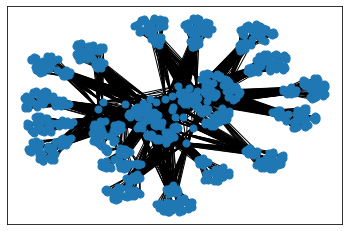

In [37]:
infection_risk_contact_type_weights={
            'very_far': 0.1, 'far': 0.1, 'intermediate': 5, 'close': 3}

for e in G.edges(data=True):
    G[e[0]][e[1]]['weight'] = infection_risk_contact_type_weights\
        [G[e[0]][e[1]]['contact_type']]

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size=50, with_labels=False)

### Visualization

#### Create fixed node positions for students and teachers

In [7]:
fixed_pos = {}
class_width = 0.2
class_x_sep = 0.2/3
class_height = 0.2
N_horizontal = 5
N_vertical = 4

# bottom row of classes
student_counter = 1
for c in range(0, 4):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * c + x * class_width / N_horizontal + \
                c * class_x_sep
            y_pos = 0 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1

# left middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = 0 + x * class_width / N_horizontal
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1
        
# right middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = class_width * 3 + x * class_width / N_horizontal + \
            3 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1

# top row of classes
for c in range(7, 11):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * (c-7) + x * class_width / N_horizontal +\
                (c - 7) * class_x_sep
            y_pos = 0.6 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1
            
# teachers
teacher_counter = 1
for x in range(0, N_horizontal):
    for y in range(0, N_vertical):
        x_pos = class_width * 1.5 + x * class_width / N_horizontal + \
            1 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'t{}'.format(teacher_counter):(x_pos, y_pos)})
        teacher_counter += 1

#### Visualize the class

In [14]:
N_teachers = N_classes * 2
students = node_list[node_list['type'] == 'student']['ID'].values
teachers = node_list[node_list['type'] == 'teacher']['ID'].values
family_members = node_list[node_list['type'] == 'family_member']['ID'].values

(-0.3, 1.3)

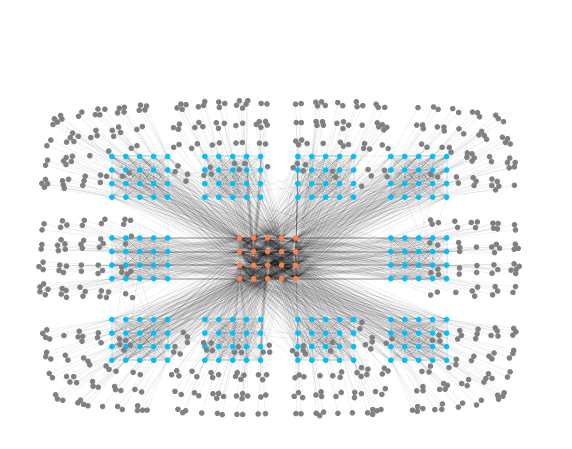

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())

node_color = ['DeepSkyBlue'] * len(students)
node_color.extend(['Coral'] * len(teachers))
node_color.extend(['grey'] * len(family_members))

all_nodes = node_list['ID'].values

nx.draw(G, pos, node_size=20, ax=ax, width = 0.05, nodelist=all_nodes, \
       node_color = node_color)
ax.set_ylim(-0.3, 1.3)
ax.set_xlim(-0.3, 1.3)

## Testing

In [462]:
# number of students in a class
class_size = 20
# number of classes in a school
N_classes = 10
# architecture
N_floors = 1
# school type
school_type = 'primary_dc'
age_bracket = age_brackets[school_type]

In [463]:
# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
N_cross_class_contacts = 0
# number of other teachers each teacher has fleeting contact with every day
N_teacher_contacts_far = 3
# number of teachers a teacher has intermediate contacts with every day
N_teacher_contacts_intermediate = 1
# if time-period == 'calibration', networks without household-members are generated
# if time-period == 'post-lockdown', networks with post-lockdown contact
# configurations (i.e. student close contacts only to table neighbours) are
# generated
time_period = 'calibration'

In [491]:
reload(csn)
G = nx.Graph()

family_member_counter, family_counter = csn.generate_students(G, school_type, 
                    age_bracket, N_classes, class_size, p_children, p_parents)

floors, floors_inv = csn.get_floor_distribution(N_floors, N_classes)
csn.generate_classes(G, age_bracket, class_size, floors_inv)

N_teachers = csn.get_N_teachers(school_type, N_classes)
teacher_nodes = ['t{}'.format(i) for i in range(1, N_teachers + 1)]
family_member_counter, family_counter =  csn.generate_teachers(G, teacher_nodes,
    family_member_counter, family_counter, teacher_p_adults, teacher_p_children)

csn.generate_teacher_contacts(G, teacher_nodes, N_teacher_contacts_far,
                         N_teacher_contacts_intermediate)

teacher_schedule, student_schedule = csn.set_teacher_student_contacts(G, \
                    school_type, N_classes, class_size)

node_list = csn.get_node_list(G)

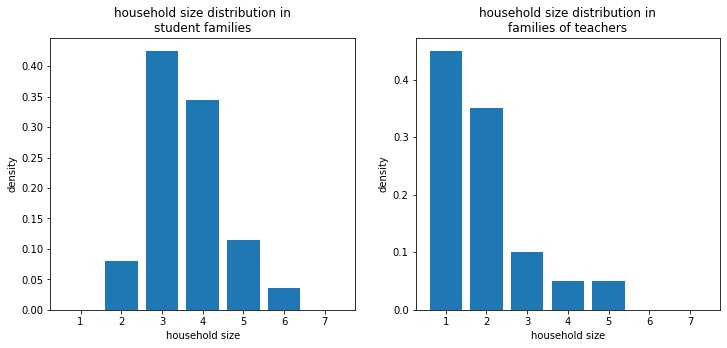

In [486]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# students
family_sizes = []
student_families = [n[1]['family'] for n in G.nodes(data=True) \
                    if n[1]['type'] == 'student']
for f in student_families:
    fsize = [n for n in G.nodes(data=True) if n[1]['family'] == f]
    family_sizes.append(len(fsize))
    
axes[0].hist(family_sizes, bins=range(1, 9), rwidth=0.8, align='left', density=True)
axes[0].set_xlabel('household size')
axes[0].set_ylabel('density')
axes[0].set_title('household size distribution in\nstudent families')

# teachers
family_sizes = []
teacher_families = [n[1]['family'] for n in G.nodes(data=True) \
                    if n[1]['type'] == 'teacher']
for f in teacher_families:
    fsize = [n for n in G.nodes(data=True) if n[1]['family'] == f]
    family_sizes.append(len(fsize))
    
axes[1].hist(family_sizes, bins=range(1, 9), rwidth=0.8, align='left', density=True)
axes[1].set_xlabel('household size')
axes[1].set_ylabel('density')
axes[1].set_title('household size distribution in\nfamilies of teachers');

In [487]:
fixed_pos = {}
class_width = 0.2
class_x_sep = 0.2/3
class_height = 0.2
N_horizontal = 5
N_vertical = 4

# bottom row of classes
student_counter = 1
for c in range(0, 4):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * c + x * class_width / N_horizontal + \
                c * class_x_sep
            y_pos = 0 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1

# left middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = 0 + x * class_width / N_horizontal
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1
        
# right middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = class_width * 3 + x * class_width / N_horizontal + \
            3 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1

# top row of classes
for c in range(7, 11):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * (c-7) + x * class_width / N_horizontal +\
                (c - 7) * class_x_sep
            y_pos = 0.6 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1
            
# teachers
teacher_counter = 1
for x in range(0, N_horizontal):
    for y in range(0, N_vertical):
        x_pos = class_width * 1.5 + x * class_width / N_horizontal + \
            1 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'t{}'.format(teacher_counter):(x_pos, y_pos)})
        teacher_counter += 1

#### Visualize the class

In [488]:
N_teachers = N_classes * 2
students = node_list[node_list['type'] == 'student']['ID'].values
teachers = node_list[node_list['type'] == 'teacher']['ID'].values
family_members = node_list[node_list['type'] == 'family_member']['ID'].values

(-0.3, 1.3)

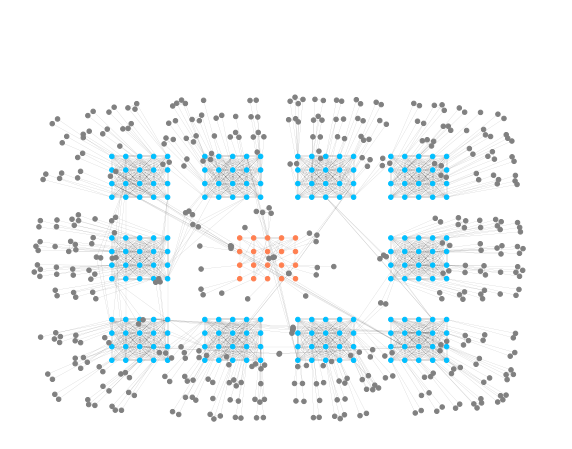

In [490]:
fig, ax = plt.subplots(figsize=(10, 8))
# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())

node_color = ['DeepSkyBlue'] * len(students)
node_color.extend(['Coral'] * len(teachers))
node_color.extend(['grey'] * len(family_members))

all_nodes = list(students)
all_nodes.extend(list(teachers))
all_nodes.extend(list(family_members))

nx.draw(G, pos, node_size=20, ax=ax, width = 0.05, nodelist=all_nodes, \
       node_color = node_color)
ax.set_ylim(-0.3, 1.3)
ax.set_xlim(-0.3, 1.3)

### Primary schools

#### The average primary school
Austrian primary schools are compulsory for children above the age of 6 and offer education according to [ISCED level 1](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education). Austrian primary schools have 4 levels, therefore students in Austrian primary schools are typically aged between 6 and 10. According to the Austrian education statistics of the year 2017/18, there are 3033 Primary schools with a total of 18,245 classes and 339,382 students in Austria. Therefore the average Austrian primary school has 8 classes with 19 students each, corresponding to two classes per level. 

#### Full-day-care
About [50% of primary schools in Austria](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf) offer full-day-care and about [25% of students in primary schools](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf) participate in full-day-care. Full-day-care is organised in two different models: integrated and separated. In the separated model, teaching ends after 4-5 hours every day and is followed by supervised lunch, work on homework and other activities for another 3-4 hours.  Since usually not all students of a school participate in the full-day-care in the separated model, classes are broken up after the teaching part of the day and students are re-distributed into a number of groups that is usually smaller than the number of classes the school has. In the integrated model, teaching is intertwined with other activities and supervised work on homework. In this model, all students participate in the full-day-care and classes are not broken up. [Of the schools that offer full-day-care, 95%]( https://www.bmbwf.gv.at/Themen/schule/schulsystem/gts/ba_standorte.html) run the separated model. To approximate these numbers, we assume that 50% of schools in our primary school ensemble offer full-day-care in which 50% of the children in these schools participate, respectively. We only model separated full-day-care, since this corresponds to the vast majority of Austrian primary schools. For afternoon supervision, students are re-organised into groups of the same size as the morning classes by randomly selecting 50% of the total number of students and randomly assigning them to M groups, where M=N/2 and N is the number of classes. 

#### Syllabus & teaching personnel
According to the [syllabus](https://www.bmbwf.gv.at/dam/jcr:f4f200c0-b999-42c8-9dba-1ca18fa89e14/lp_vs_vierter_teil_14042.pdf) for Austrian primary schools, Austrian kids spend between 20 and 25 hours at school every week. Out of this total amount of hours, 11 hours are spent learning primary subjects (reading, writing, math, information retrieval), the other hours are spent learning minor subjects (sports, religion, creative subjects). We approximate this syllabus in the following way: Children in our simulated primary schools spend 20 hours / week or 4 hours / day at school. Every day, the first two hours are allotted to learning primary subjects, whereas the rest of the day is alloted to secondary subjects. Primary subjects are all taught by a single teacher for every class, respectively ("class teacher"), whereas secondary subjects are taught by different teachers. 

According to the [financing regulations for Austrian primary schools](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf), 1.5 teachers / class are financed in Austrian schools. Nevertheless, this number does not include staff needed for additional offers such as full-day-care, language classes or religion classes. According to the Austrian school statistics 2017/18, the [total number of teachers in primary schools](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd/lehrstat_oester.html) was 33050, whereas the [number of classes was](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) 18245, yielding an average of 1.81 teachers per class. Unfortunately, this number cannot be stratified for schools with and without full-day-care. This number also only reflects the number of full-time equivalents alloted for teaching and not the true number of persons that are involved in teaching, which might be higher if a share of teachers only works part-time. According the structured interview we conducted with a director of a primary school offering full-day-care, the number of teachers was 14 for a school with 6 classes, yielding an average of 2.3 teachers per class. Since the primary school we interviewed offered full-day-care organised into 4 afternoon supervision groups, this number included personnel to supervise students in the afternoon. 

To approximate this situation, we model schools without full-day-care to have 1.5 teachers per class, and each teacher has contact to a total of two different classes (every day, but also over the course of the week). The low number of classes reflects the fact that teaching in primary schools is still largely organized around a focal class teacher that teaches the same class for extended periods of time in several primary subjects. We model schools with full-day-care to have 2 teachers per class, where each teacher still has contact to a total of two different classes, and half of the teachers supervise an afternoon care group in addition to teaching. 

In [51]:
15/5

3.0

In [ ]:
def generate_schedule(G, school_type)

    # assign each teacher to a number of classes corresponding to the number of
    # classes taught by each teacher (N_classes_taught). 
    schedule = {t:[] for t in teacher_nodes}
    circular_class_list = list(range(1, N_classes + 1)) * 2
    for i, t in enumerate(teacher_nodes):
        schedule[t] = circular_class_list[i % N_classes:\
                                          i % N_classes + N_classes_taught]
        
    # generate the contact network between the teachers and the students in the
    # classes they teach
    for t in teacher_nodes:
        for c in schedule[t]:
            students_in_class = [x for x,y in G.nodes(data=True) if \
                                (y['type'] == 'student') and \
                                 y['unit'] == 'class_{}'.format(c)]
            
            for s in students_in_class:
                G.add_edge(t, s, link_type='student_teacher', 
                           contact_type='far')
                
    return G, schedule